In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pdr as pdr
from netCDF4 import Dataset
import PyMieScatt as ps

#Add the src/radiation directory to the system path
sys.path.append(os.path.abspath(os.path.join('..', 'src', 'radiation')))

import radiative_transfer_paul as rt

# Github: https://github.com/MiriCaradonna/planetary_remote_sensing

## ASTR 5830 Final Project: Mineralogy Analysis using CRISM, with Perseverance rover context

For this project, I am performing a mineralogical study on data from the Compact Reconnaissance Imaging Spectrometer for Mars (CRISM), an instrument on Mars Reconnaisance Orbiter (MRO). This involves performing an atmospheric correction to remove the contribution of Martian dust from the spectra, then comparing the corrected spectra to results from the persevearance rover. Literature detailing spectra gained from samples taken by the persevearance rover should give me a clue on what minerals are detected in my corrected spectra.

## 1. Obtaining CRISM data

#### To gather CRISM data, I went to the Mars Orbital Data Explorer, and searched for Map-Projected Targeted Reduced Data Record (MTRDR) files from MRO: https://ode.rsl.wustl.edu/mars/index.aspx

The data I gathered was taken on May 19th, 2007 (MY28), and displays the I/F as a function of wavelength and position. I/F is also called the 'radiance factor' and is the ratio of the radiance of the object to the radiance of a lambertian surface, at a specific wavelength.


In [332]:
# Reading in the CRISM data
img = pdr.read(r"D:\SteamLibrary\frt00005c5e_07_if166j_mtr3\frt00005c5e_07_if166j_mtr3.img")

In [333]:
# Setting the extent parameters for my data, taken from the lbl file
MINIMUM_LATITUDE  =  18.3646720 
MAXIMUM_LATITUDE  =  18.6350470 
WESTERNMOST_LONGITUDE  =  77.2791950 
EASTERNMOST_LONGITUDE  =  77.5587930 

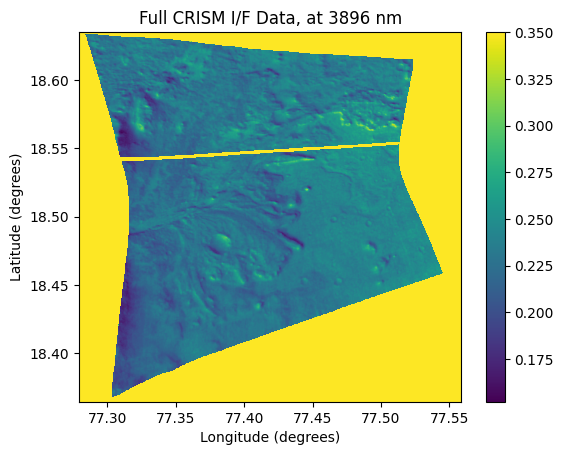

In [350]:
# Plotting the full CRISM image, at the last wavelength
plt.imshow(img['image_cube'][480,:,:], extent = [WESTERNMOST_LONGITUDE, EASTERNMOST_LONGITUDE, MINIMUM_LATITUDE, MAXIMUM_LATITUDE], vmax = 0.35)
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Full CRISM I/F Data, at 3896 nm')
plt.colorbar()

#### I decided I wanted to study the delta, so I sliced my image to zoom in on that region

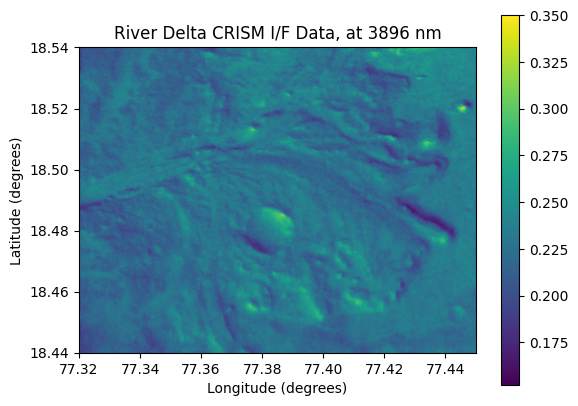

In [349]:
# Plotting the zoomed-in CRISM image, to show the region I'm focusing on
plt.imshow(img['image_cube'][480,:,:], vmax = 0.35, extent = [WESTERNMOST_LONGITUDE, EASTERNMOST_LONGITUDE, MINIMUM_LATITUDE, MAXIMUM_LATITUDE])
plt.xlim(77.32, 77.45)
plt.ylim(18.44, 18.54)
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('River Delta CRISM I/F Data, at 3896 nm')
plt.colorbar()

#### Next, I'm going to plot the median I/F data as a function of wavelength

In [351]:
# Calculating the median I/F for each wavelength
median_if = []
for i in range(len(img['image_cube'])):
    mid = np.median(img['image_cube'][i,325:650,150:550])
    median_if.append(mid)

In [354]:
# Reading in the CRISM data .tab file with the wavelength information
df = pd.read_csv(r"D:\SteamLibrary\frt00005c5e_07_if166j_mtr3\frt00005c5e_07_wv166j_mtr3.tab", header = None)

#Converting the wavelength column in the DataFrame to a NumPy array
wavelengths = np.array(df[2])

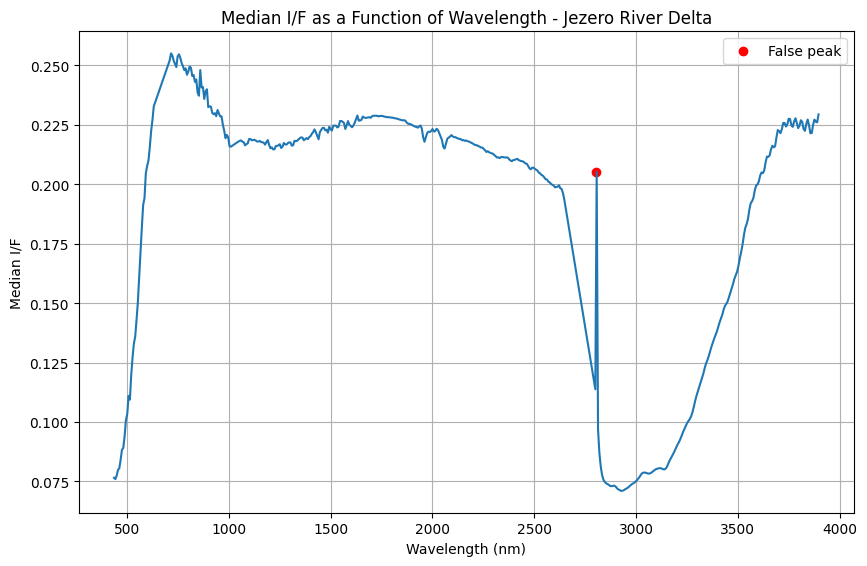

In [363]:
plt.figure(figsize=[10,10/1.6])
plt.plot(wavelengths, median_if)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Median I/F')
plt.title('Median I/F as a Function of Wavelength - Jezero River Delta')
plt.scatter(2805,0.205,color = 'red', label = 'False peak')
plt.legend()
plt.grid(True)

I noticed a sharp peak in my data, around 2800 nm. This is probably non-physical, so I'm going to remove it.

#### Removing instrument errors from my I/F spectra

In [364]:
# Looping through the data and removing sudden very sharp peaks (>0.1 I/F diference between pixels)
median_if_corrected = []
wavelengths_corrected = []
for i in range(len(median_if)-1):
    if (median_if[i] - median_if[i+1]) < 0.1:
        median_if_corrected.append(median_if[i])
        wavelengths_corrected.append(wavelengths[i])
    else:
        continue

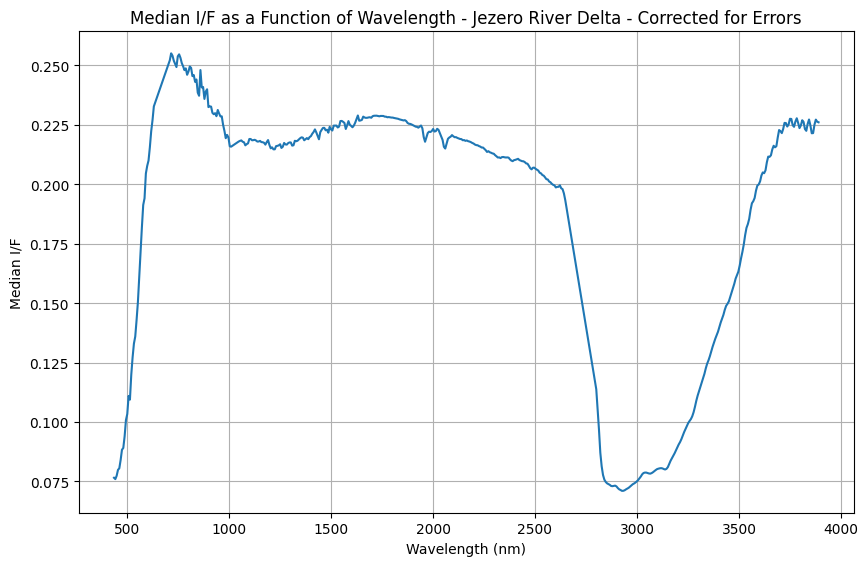

In [365]:
plt.figure(figsize=[10,10/1.6])
plt.plot(wavelengths_corrected, median_if_corrected)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Median I/F')
plt.title('Median I/F as a Function of Wavelength - Jezero River Delta - Corrected for Errors')
plt.grid(True)

Looks great! Now I can perform the atmospheric correction!

## 2. Performing the Atmospheric Dust Correction

To perform the atmospheric correction, I will be following the method described in appendix A of this paper: https://doi.org/10.1016/j.icarus.2014.08.045

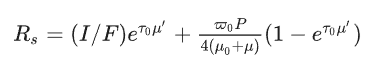

Where: \
$R_{s}$ = Surface reflectance \
$(I/F)$ = Radiance factor \
$\tau_{0}$ = Optical depth \
$\mu_{0}$ = $\cos$($\theta_{in}$) \
$\mu$ = $\cos$($\theta_{em}$) \
$\mu^{'}$ = 1/((1/$\mu_{0}$) + (1/$\mu$)) \
$\varpi_{0}$ = single-scattering albedo \
$P$ = Henyey-Greenstein Phase Function:




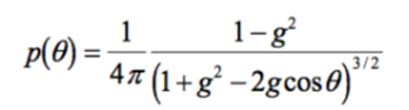

Where: \
$g$ = Asymmetry Parameter \
$\theta$ = emission angle

#### First, I need to get the emission and incidence angles from the CRISM data files

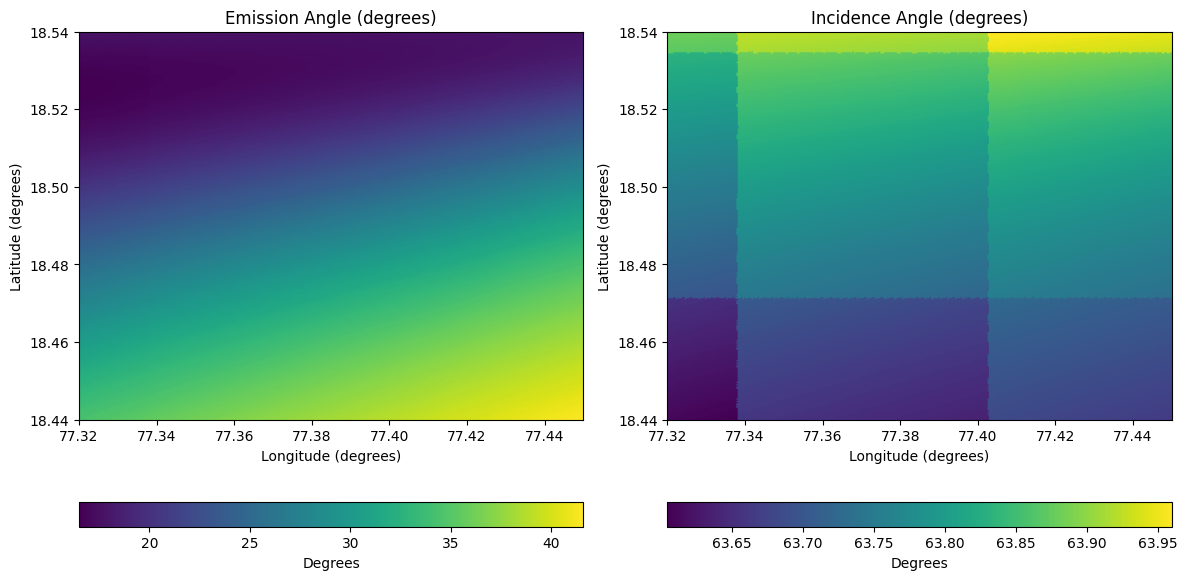

In [378]:
#Importing the file with the emission and incidence nalges
img_phase = pdr.read(r"D:\SteamLibrary\frt00005c5e_07_if166j_mtr3\frt00005c5e_07_de166l_mtr1.img")
lbl_phase = pdr.read(r"D:\SteamLibrary\frt00005c5e_07_if166j_mtr3\frt00005c5e_07_de166l_mtr1.lbl")

# Plotting the emission and incidence angles
plt.figure(figsize = [12,12/1.6])

# Emission angle
plt.subplot(1,2,1)
im1 = plt.imshow(lbl_phase['IMAGE'][1,325:650,150:550], extent = [77.32, 77.45,18.44, 18.54])
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Emission Angle (degrees)')
plt.colorbar(im1, fraction=0.046, pad=0.12, orientation = 'horizontal', label = 'Degrees')

# Incidence angle
plt.subplot(1,2,2)
im2 = plt.imshow(lbl_phase['IMAGE'][0,325:650,150:550], extent = [77.32, 77.45,18.44, 18.54])
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Incidence Angle (degrees)')
plt.colorbar(im2, fraction=0.046, pad=0.12, orientation = 'horizontal', label = 'Degrees')

plt.tight_layout()
plt.show()

In [398]:
# Taking the mean of the incidence and emission angles for the area I'm studying
in_angle = np.mean(lbl_phase['IMAGE'][0,325:650,150:550]) * (np.pi/180)
em_angle = np.mean(lbl_phase['IMAGE'][1,325:650,150:550]) * (np.pi/180)

# Taking the cosine of the emission and incidence angles to get mu and mu_0
mu_0 = np.cos(in_angle)
mu = np.cos(em_angle)

# Combining mu_0 and mu to get mu_prime
mu_prime = ((1/mu_0) + (1/mu))**-1

print('The mean incidence angle and its cosine are: %f degrees, %f' %(in_angle/(np.pi/180), mu_0))
print('The mean emission angle and its cosine are: %f degrees, %f' %(em_angle/(np.pi/180), mu))

The mean incidence angle and its cosine are: 63.765038 degrees, 0.442053
The mean emission angle and its cosine are: 26.996571 degrees, 0.891034


#### Now, I need to find the optical depth of the dust as a function of wavelength

I used this website to download martian dust optical depth data for MY28: https://www-mars.lmd.jussieu.fr/mars/dust_climatology/  \
This file is a composite of data from Mars Climate Sounder and Mars Reconnaissance Orbiter, and gives me the optical depth of the dust measured at 9.3 $\mu$m. 

In [387]:
# Importing the optical depth data file
rootgrp = Dataset(r"C:\Users\Mirie\Downloads\griddedcdod_MY28_v2-0.nc")

# Getting the total optical depth from the file
optical_depth = rootgrp.variables['cdodtot']

#Setting the solar longitude that the CRISM data was taken at (found in the .lbl file), so I can match up the CRISM data with the optical depth data
Ls = 485

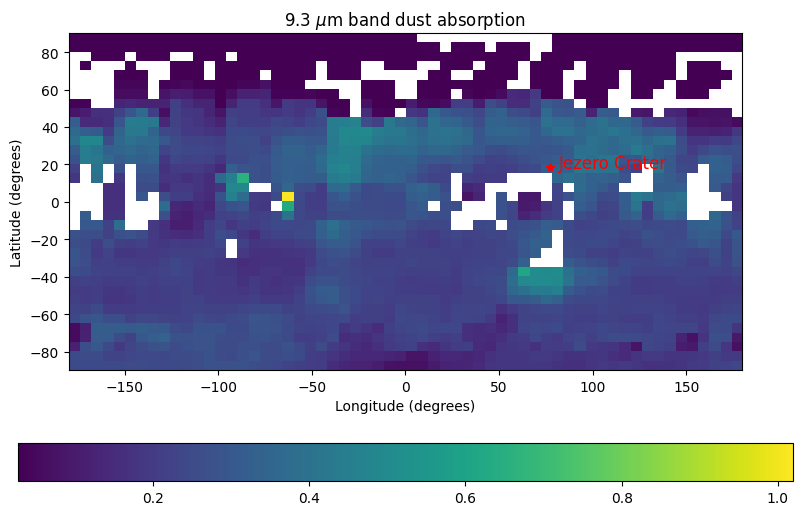

In [388]:
# Plotting the optical depth data as a function of wavelength, at the correct L_s
plt.figure(figsize = [10,10/1.6])
plt.imshow(optical_depth[Ls,:,:], extent = [-180, 180, -90, 90])
plt.plot(77.37, 18.45, marker = '*', color = 'red')
plt.text(82, 18, 'Jezero Crater', color = 'red', fontsize = 'large') # weight = 'semibold')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('9.3 $\mu$m band dust absorption')
plt.colorbar(orientation = 'horizontal')

Here I have plotted the latitude and longitude of Jezero Crater, so that I can pull the optical depth at that location

Now that I have the optical depth data, I need to convert from absorption to extinction. \
To do this, I followed the procedure laid out in this paper, which is attached to the datafile:  https://www.sciencedirect.com/science/article/pii/S0019103515000044?via=ihub#s0055 \
The paper says that, to convert from the absorption at 9.3 microns, to extinction in the visible (~500 nm), we have to multiply the optical depth at 9.3 $\mu$m by 2.6

In [399]:
# Pulling the optical depth at the pixel where Jezero Crater is
tau_9_3_abs = optical_depth[Ls,14,42]

# Converting from 9.3 micron absorption to extinction in the visible, at ~500 nm
tau_500_ext = 2.6 * tau_9_3_abs
print('The optical depth of the Martian dust at ~500 nm is: %f' %tau_500_ext)

The optical depth of the Martian dust at ~500 nm is: 0.816678


Now that I have the optical depth at 500 nm, I can use the following equation to convert from the optical at 500 nm to optical dpeth at any wavelength:

$\LARGE\tau(\lambda_{2})$ = $\LARGE\frac{Q_{ext}(\lambda_{2})}{Q_{ext}(\lambda_{1})}$ $\LARGE\times$ $\LARGE\tau(\lambda_{1})$

Where: \
$\tau({\lambda_{2}})$ = optical depth at any wavelength \
$\tau({\lambda_{1}})$ = optical depth at 500 nm \
$Q_{ext}({\lambda_{2}})$ = extinction efficiency at any wavelength \
$Q_{ext}({\lambda_{1}})$ = extinction efficiency at 500 nm



To use this equation, I first need to calculate the extinction efficiency at a function of wavelength. To do this, I need to perform a forward mie parameter calculation, and I need the real and imaginary components of the index of refraction for Martian dust.

I gathered the real and imaginary components of the index of refraction for Martian dust from Clancy and Wolff (2003)

In [400]:
# Reading in the real and imaginary index of refraction from Clancy and Wolff (2003):
dust = pd.read_csv(r"C:\Users\Mirie\Downloads\clancy_wolfe_dust.wnr", header = None, sep = ' ')
dust.columns = ['NaN','lambda', 'real', 'im']

#converting the columns to arrays
lambdas = np.array(dust['lambda']) * 1000 #converting microns to nm
real_n = np.array(dust['real'])
im_n = np.array(dust['im'])

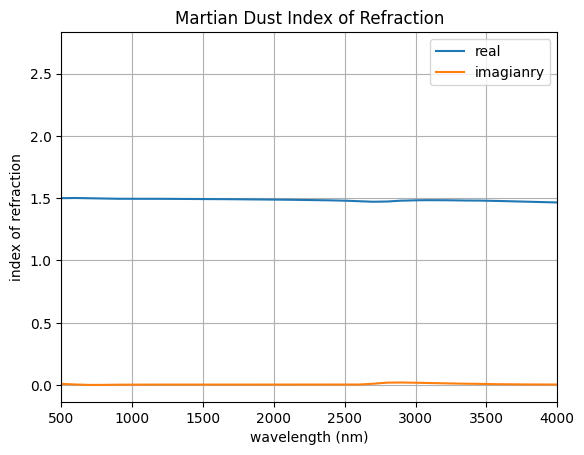

In [401]:
# Plotting the real and imaginary components in the wavelegnth range of my CRISM data
plt.plot(lambdas, real_n, label = 'real')
plt.plot(lambdas, im_n, label = 'imagianry')
plt.xlim(500, 4000)
plt.xlabel('wavelength (nm)')
plt.ylabel('index of refraction')
plt.title('Martian Dust Index of Refraction')
plt.legend()
plt.grid(True)

Great! Now that I have the index of refraction, I can perform the forward mie scattering calculation

In [403]:
# Assumign a particle diameter of 3 microns, based on in-class discussions
diameter = 3e-6 #in meters

# Combing the real and imaginary parts
m_arr = real_n + 1j*im_n

# Performing the foward mie scattering calculation, using PyMieScatt
mie_params_3 = []
i = 0
while i < len(m_arr):
#for i in range(len(m_arr)):
    Qext_1,Qsca_1,Qabs_1,g_1,Qpr,Qback,Qratio= ps.AutoMieQ(m_arr[i],(lambdas[i] * 1e-9),diameter)
    ssa_1 = Qsca_1/Qext_1 # calculating single-scattering albedo from Qext and Qsca
    mie_params_3.append([Qext_1,Qsca_1,Qabs_1,g_1,ssa_1])

    i+=1

The forward mie scattering calculation also gave me the single-scattering albedo and the asymmetry parameter as a function of wavelength, which I need to calculate the surface reflectance!

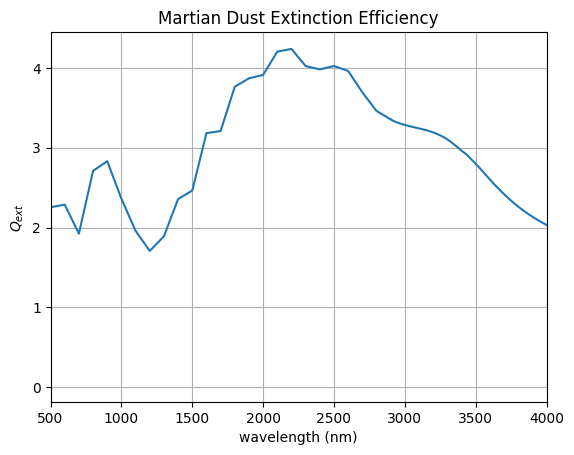

In [404]:
# Getting Q_ext, ssa, and g as arrays
def column(matrix, i):
    return [row[i] for row in matrix]

Qext_3_arr = column(mie_params_3,0)
ssa_3_arr = column(mie_params_3,4)
g_3_arr = column(mie_params_3,3)

# Plotting the extinction efficiency as a function of wavelength, in the wavelength range of the CRISM data
plt.plot(lambdas, Qext_3_arr)
plt.xlim(500, 4000)
plt.xlabel('wavelength (nm)')
plt.ylabel('$Q_{ext}$')
plt.title('Martian Dust Extinction Efficiency')
plt.grid(True)

Now that I have the extinction efficiency as a function of wavelength, I can calculate the optical depth as a function of wavelength!

In [413]:
# Pulling the extinction efficiency at 500 nm
Q_ext_500 = Qext_3_arr[3]

# Calculating the optical depth as a function of wavelegnth, using the equation described above
tau_ext_3 = []
for i in range(len(Qext_3_arr)):
    tau = (Qext_3_arr[i] / (Q_ext_500) * tau_500_ext)
    tau_ext_3.append(tau)

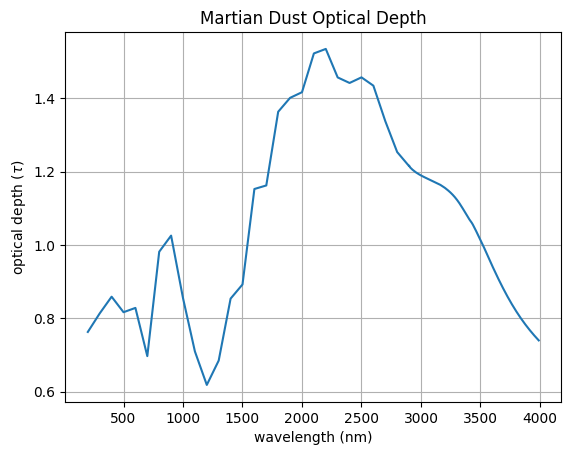

In [415]:
# Plotting the optical depth as a function of wavelength in the wavelength range of the CRISM data
plt.plot(lambdas[0:145], tau_ext_3[0:145])
plt.xlabel('wavelength (nm)')
plt.ylabel(r'optical depth ($\tau$)')
plt.title('Martian Dust Optical Depth')
plt.grid(True)

Now that I have all the pieces, I can perform the atmospheric correction!

In [416]:
# Reflectance spectrum equation, described in equation above
def reflectance_spec(mu, mu_0, mu_prime, g, I_F, tau, ssa):
    P = rt.henyey_greenstein(mu, g)
    R_direct = I_F * np.exp(-tau * mu_prime)
    R_diffuse = ((ssa * P)/(4 * (mu + mu_0))) * (1 - np.exp(-tau * mu_prime))

    return (R_direct + R_diffuse)

The optical depth, ssa, and g arrays are smaller than the I/F array, so I need to interpolate the optical depth, ssa, and g data to match the size of the I/F data

In [418]:
# Performing the interpolation of the optical depth, ssa, and g arrays
from scipy.interpolate import interp1d

# Original array and its x-coordinates
tau_original = tau_ext_50[0:145]
ssa_original = ssa_50_arr[0:145]
g_original = g_50_arr[0:145]
lambdas_original = lambdas[0:145]

# Desired size and new x-coordinates
new_size = len(median_if_corrected)
x_new = wavelengths_corrected

# Interpolation function
f_tau = interp1d(lambdas_original, tau_original, kind='linear')
f_ssa = interp1d(lambdas_original, ssa_original, kind='linear')
f_g = interp1d(lambdas_original, g_original, kind='linear')

# Interpolated array
interpolated_tau = np.array(f_tau(x_new))
interpolated_ssa = np.array(f_ssa(x_new))
interpolated_g = np.array(f_g(x_new))

In [419]:
# Performing the atmospheric correction and getting the surface reflectance
R_s = reflectance_spec(mu, mu_0, mu_prime, interpolated_g, median_if_corrected, interpolated_tau, interpolated_ssa)

Great! We did it! Now we can look at the reflectance spectrum and see what features pop out...

## 3. Analyzing the corrected spectrum

I wanted to do some sort of analysis on the perseverance data myself, but the data files proved too difficult to unpack and decipher for this project. However, I  was able to dig into the literature to see what others have found by analyzing CRISM and perseverance data.

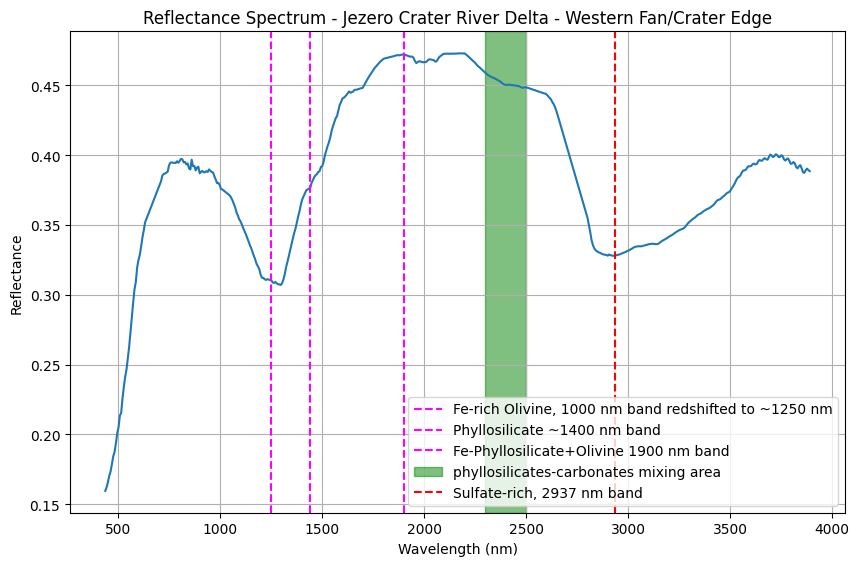

In [424]:
plt.figure(figsize=[10,10/1.6])
plt.plot(wavelengths_corrected, R_s)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Reflectance Spectrum - Jezero Crater River Delta - Western Fan/Crater Edge')
plt.axvline(x = 1250, color = 'magenta', linestyle = '--', label = 'Fe-rich Olivine, 1000 nm band redshifted to ~1250 nm')
plt.axvline(x = 1440, color = 'magenta', linestyle = '--', label = 'Phyllosilicate ~1400 nm band')
plt.axvline(x = 1900, color = 'magenta', linestyle = '--', label = 'Fe-Phyllosilicate+Olivine 1900 nm band')
plt.axvspan(2300,2500, color = 'green', alpha = 0.5,label = 'phyllosilicates-carbonates mixing area')
plt.axvline(x = 2937, color = 'red', linestyle = '--', label = 'Sulfate-rich, 2937 nm band')
plt.grid(True)
plt.legend()

Overall, it's difficult to label the cause of spectral features without doing something like spectral unmixing or some kind of other fitting method, however, I can speculate with varying degrees of confidence. 

In the spectra, there are two broad absorption bands, roughly centered at 1200 nm and 2900 nm, respectfully. 

$\textbf{1200 nm broad band - Fe-rich Olivine:}$ \
Based on this paper by Brown et al (2020) where they used data from CRISM: https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2019JE006011 I belive this broad band is the olivine band that usually appears at 1000 nm. However, the authors say, "The position of the 1 μm olivine band is sensitive to the Mg versus Fe content, where more Fe‐rich olivine displays a longer redshifted 1 μm band position". So, with a fair bit of confidence, I labeled this broad band as Fe-rich olivine. 

However, there's more to the story here. The authors make a distinction between Fe-carbonate and Fe-phyllosilicate. Both Fe-carbonates and           Fe-phyllosilicates show absorption bands at 2300 nm, while only the Fe-phyllosilicates show an absorption line at 1900 nm, and only the Fe-carbonates show an absorption line at 2500 nm. Based on Figure 6c and 6d, from Brown et al (2020) (see figure below), I believe my CRISM image contains regions of both Fe-carbonates and Fe-phyllosilicates. The river delta is mainly phyllosilicates, but my CRISM image includes a region north of the riverbed containing carbonates. 

In my spectrum, it's difficult to pick out the narrow absoprtion bands at 1900, 2300, and 2500 nm for these Fe-phyllosilicates and Fe-carbonates, especially since I had to interpolate the optical depth, ssa, and g data, so I can't with 100% confidence say that these absoprtion lines are there just by inspection. 

However, this paper by Royer et al (2025), using Persevearance/Super-Cam data, claims that the steep slope between 1300-1800 nm is attributed to Fe-carbonate+olivine: https://www.sciencedirect.com/science/article/pii/S0019103525000855#sec3.4
and claims that the 2300-2500 nm region is the phyllosilicate-carbnate mixing area where, if both are present, the distinct 2300 nm line becomes many smaller absorption lines, centered redward of 2300 nm. I can't say confidently that these small lines are present, but that region in my spectrum exhibits similar characteristics. 

Also, this paper by Cao et al (2025) used SHERLOC data from Persevearance, and claims that there's an absorption line at 1400 nm due to hydrated silicates: https://doi.org/10.1029/2024JE008750 \
This paper supports the results of the Brown et al (2020) paper and the Royer et al (2025) paper, claiming that there's also regions of carbonates in the river delta region.

In my reflectance spectra, I have marked the regions corresponding to this Fe-rich olivine with a dashed magenta line, and the phyllosilicate-carbonate mixing region with the green band.



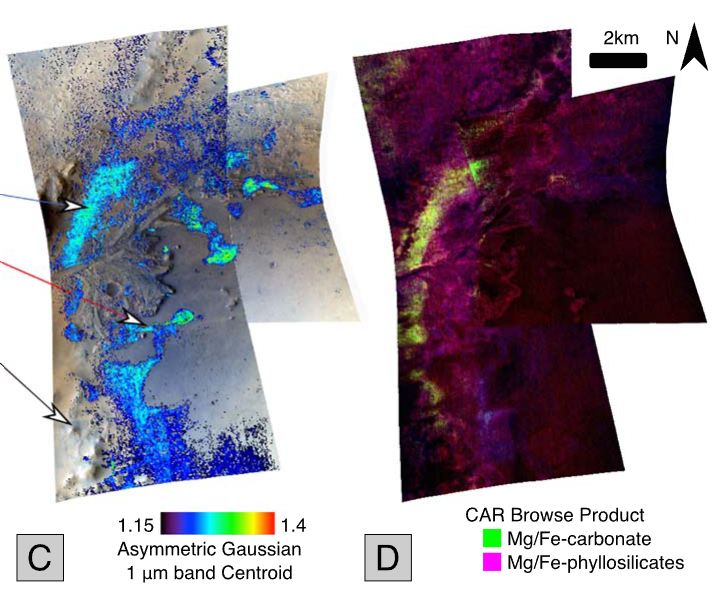

$\textbf{Figure 6c and 6d, from Brown et al (2020)}$

$\textbf{2937 nm broad band - Sulfates:}$ \
In the Cao et al (2025) paper, using SHERLOC data from perseverance, they claim that the broad band centered at 2937 nm is due to the sulfate OH-stretching mode, which is similar to the Raman spectrum displayed by gypsum. Based on Figure 2 (see below), my CRISM image contains region A, where the sulfate measurement occured. 

The sulfate absorption band is marked by a red dashed line in my reflectance spectrum above.

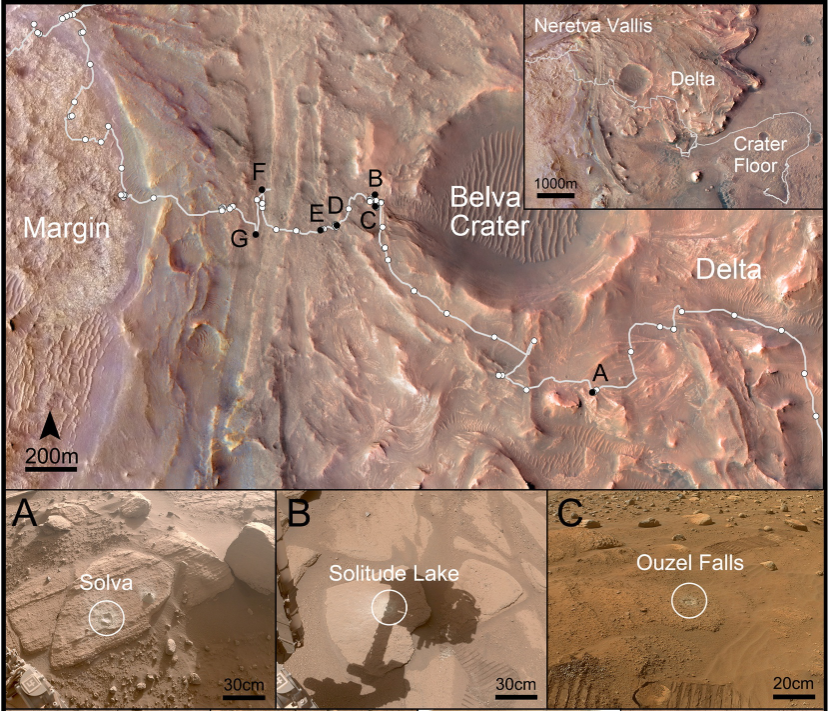
$\textbf{Figure 2 from Cao et al (2025)}$

I think it would be interesting to see if these features show up in my CRISM I/F images. What I can do is take the CRISM image at the wavelengths where I see absorption, and divide the image by the median I/F at that wavelength. My idea is that, the closer the pixel is to 1, the closer it is to the median I/F (or the center of the band), and the higher the chance that pixel contains that mineral. Let's see...

### Broad band: 1250 nm, Fe-rich Olivine

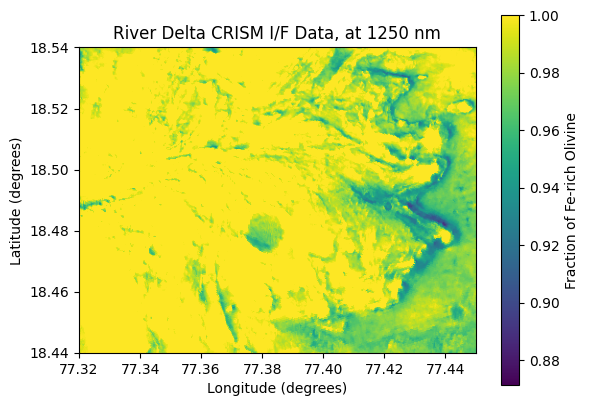

In [441]:
plt.imshow(img['image_cube'][109,:,:]/median_if_corrected[109], vmax = 1, extent = [WESTERNMOST_LONGITUDE, EASTERNMOST_LONGITUDE, MINIMUM_LATITUDE, MAXIMUM_LATITUDE])
plt.xlim(77.32, 77.45)
plt.ylim(18.44, 18.54)
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('River Delta CRISM I/F Data, at 1250 nm')
plt.colorbar(label = 'Fraction of Fe-rich Olivine')

Seems like the pixels that match the band center (median I/F) of the 1250 nm Fe-rich olivine band are all within the delta! As you go towards the crater floor, the Fe-rich olivine starts to drop off.

### Broad-band: 2937 nm, Sulfates

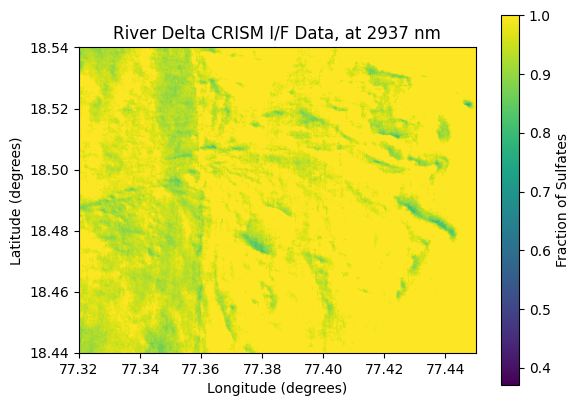

In [454]:
plt.imshow(img['image_cube'][343,:,:]/median_if_corrected[343], vmax = 1, extent = [WESTERNMOST_LONGITUDE, EASTERNMOST_LONGITUDE, MINIMUM_LATITUDE, MAXIMUM_LATITUDE])
plt.xlim(77.32, 77.45)
plt.ylim(18.44, 18.54)
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('River Delta CRISM I/F Data, at 2937 nm')
plt.colorbar(label = 'Fraction of Sulfates')

Most of the delta lights up as containing sulfates! I think it's interesting that there's a distinct line at the end of the river bed before the delta begins where the fraction of sulfates drops off. The region that contained the sulfate detection in the Cao et al (2025) paper (region A) lights up too!

### Possible narrow band: Fe-carbonates+olivine, ~2500 nm

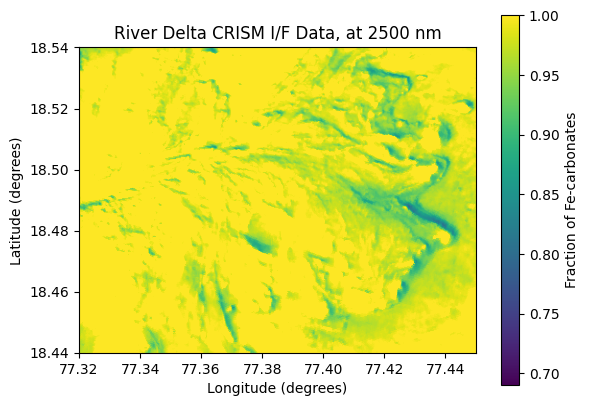

In [460]:
plt.imshow(img['image_cube'][299,:,:]/median_if_corrected[299], vmax = 1, extent = [WESTERNMOST_LONGITUDE, EASTERNMOST_LONGITUDE, MINIMUM_LATITUDE, MAXIMUM_LATITUDE])
plt.xlim(77.32, 77.45)
plt.ylim(18.44, 18.54)
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('River Delta CRISM I/F Data, at 2500 nm')
plt.colorbar(label = 'Fraction of Fe-carbonates')

Seems to somewhat match up with figure 6d in the Brown et al (2020) paper; the region with the high carbonate region in figure 6d also lights up as close to 1 in my image! I do think it's odd that the carbonates show up in the delta, which doesn't agree with figure 6d...

### Possible narrow band: Fe-phyllosilicates+olivine, ~1900 nm

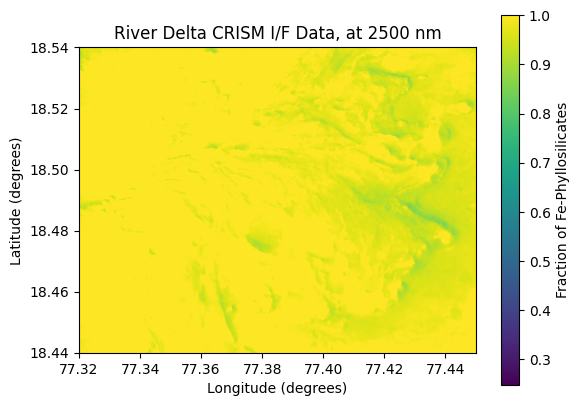

In [467]:
plt.imshow(img['image_cube'][208,:,:]/median_if_corrected[208], vmax = 1, extent = [WESTERNMOST_LONGITUDE, EASTERNMOST_LONGITUDE, MINIMUM_LATITUDE, MAXIMUM_LATITUDE])
plt.xlim(77.32, 77.45)
plt.ylim(18.44, 18.54)
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('River Delta CRISM I/F Data, at 2500 nm')
plt.colorbar(label = 'Fraction of Fe-Phyllosilicates')

Also seems to mostly match up with figure 6d in the Brown et al (2020) paper; most regions within the delta light up as containing Fe-phyllosilicates, and only drops off a bit closer to the crater floor.

Overall, I believe my spectra show clear signatures of Fe-rich olivine around 1250 nm and sulfates (gypsum, possibly?) around 2937 nm. The literature also shows varying amounts of Fe-carbonate and Fe-phyllosilicates, although I cannot say with full confidence that those features appear in my spectra without performing a strict analysis of the spectra, using spectral unmixing, or examining the perseverance data myself.